In [1]:
import re
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("labeled_data.csv")
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


In [4]:
tweet = df["tweet"]

In [5]:
corpus = []
for i in range(len(df)):
  review = re.sub('[^a-zA-Z]', ' ', tweet[i])
  review = review.lower()
  review = review.split()
  ps = PorterStemmer()
  all_stopwords = stopwords.words('english')
  all_stopwords.remove('not')
  review = [ps.stem(word) for word in review if not word in set(all_stopwords)]
  review = ' '.join(review)
  corpus.append(review)

In [6]:
vectorizer = CountVectorizer(max_features = 2000)

In [7]:
x = vectorizer.fit_transform(corpus)

In [8]:
x = x.toarray()

In [9]:
x = x.astype("float32")

In [10]:
labels = df["class"]
t = labels.astype("int32")
print(np.unique(t))
print("number of class 0: ", len(df[df["class"] == 0]), "number of class 1:", len(df[df["class"] == 1]), "number of class 2:", len(df[df["class"] == 2]))

[0 1 2]
number of class 0:  1430 number of class 1: 19190 number of class 2: 4163


In [11]:

x_train, x_test, t_train, t_test = train_test_split(x, t, train_size=0.7, random_state=0)

In [12]:
_, n_input = x_train.shape

In [13]:
n_output = len(np.unique(t_test))

In [14]:
total = len(df)
class_weight = {
    0: total/len(df[df["class"] == 0]),
    1: total/len(df[df["class"] == 1]),
    2: total/len(df[df["class"] == 2]),
}

In [15]:
model = models.Sequential([
    layers.Dense(200, input_shape=(n_input, ), activation="relu"),
    layers.Dense(n_output, activation="softmax")
])

optimizer = tf.keras.optimizers.SGD(lr=0.01)
model.compile(loss="sparse_categorical_crossentropy",
             optimizer=optimizer,
             metrics=["accuracy"])

In [16]:
history = model.fit(
    x_train,
    t_train,
    batch_size=128,
    epochs=50,
    verbose=1,
    validation_data=(x_test, t_test),
    class_weight=class_weight
)

Epoch 1/50
136/136 [==============================] - 2s 14ms/step - loss: 3.1646 - accuracy: 0.7081 - val_loss: 0.9583 - val_accuracy: 0.7416
Epoch 2/50
136/136 [==============================] - 2s 12ms/step - loss: 2.8516 - accuracy: 0.7540 - val_loss: 0.8368 - val_accuracy: 0.7494
Epoch 3/50
136/136 [==============================] - 1s 10ms/step - loss: 2.5164 - accuracy: 0.7689 - val_loss: 0.7220 - val_accuracy: 0.7875
Epoch 4/50
136/136 [==============================] - 1s 10ms/step - loss: 2.2329 - accuracy: 0.7928 - val_loss: 0.6650 - val_accuracy: 0.8066
Epoch 5/50
136/136 [==============================] - 1s 10ms/step - loss: 2.0085 - accuracy: 0.8106 - val_loss: 0.6306 - val_accuracy: 0.8118
Epoch 6/50
136/136 [==============================] - 2s 11ms/step - loss: 1.8376 - accuracy: 0.8165 - val_loss: 0.5950 - val_accuracy: 0.8134
Epoch 7/50
136/136 [==============================] - 2s 11ms/step - loss: 1.7098 - accuracy: 0.8157 - val_loss: 0.5714 - val_accuracy: 0.8134

In [17]:
results = pd.DataFrame(history.history)
results.tail(3)

,loss,accuracy,val_loss,val_accuracy
47,0.792777,0.881312,0.411135,0.855817
48,0.783915,0.883099,0.407339,0.858911
49,0.776906,0.884194,0.429779,0.847075


Text(0.5, 0, 'epochs')

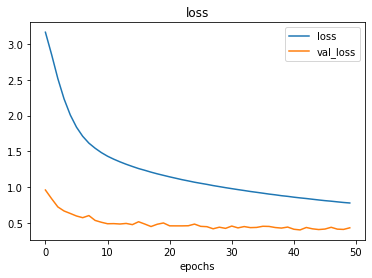

In [18]:
results[["loss", "val_loss"]].plot(title="loss")
plt.xlabel("epochs")

Text(0.5, 0, 'epochs')

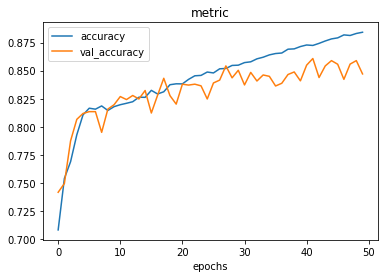

In [19]:
results[["accuracy", "val_accuracy"]].plot(title="metric")
plt.xlabel("epochs")